In [2]:
import numpy as np
import pandas as pd 
import re
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
# import nltk
# import spacy                                       ## pip install -U spacy
# from nltk.tokenize.toktok import ToktokTokenizer
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [3]:
from nltk.cluster import KMeansClusterer
import nltk
from sklearn.manifold import TSNE

In [4]:
from sklearn.cluster import KMeans

In [5]:
import numpy as np
import seaborn as sns

In [6]:
data = pd.read_csv('fbportal_updated.csv')
data.head()

,Test Case Description,Label
0,What's the weather like in Chicago?,Weather
1,What is the forecast in Tampa for tomorrow?,Weather
2,What is the weather in Oregon today?,Weather
3,Is it raining in France right now?,Weather
4,Show me the weather in Mexico for next week.,Weather


In [7]:
def text_cleaner(text):
   
    newString = text.lower()
    newString = re.sub(r"pre-conditions: ","",newString)
    newString = re.sub(r"precondition: ","",newString)
    newString = re.sub(r"[^a-zA-Z0-9]+", ' ', newString)
    #newString = remove_stopwords(newString)
    return newString

In [8]:
#call the function
cleaned_text = []
data['Test Case Description']=data['Test Case Description'].astype(str)
for t in data['Test Case Description']:
    cleaned_text.append(text_cleaner(t))
data['cleaned_text']=cleaned_text

## Sentence Embedding and applying clustering on it by using sentence_transformers

#### Trying with all-distilroberta-v1 pre-trained model

In [9]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-distilroberta-v1')

In [10]:
def embeddings(data):
    sentence_embeddings = model.encode(list(data['cleaned_text']))
    return sentence_embeddings
embeddings_trs=embeddings(data)
data['embediing_trf_roberta']=list(embeddings_trs)

In [11]:
data['embediing_trf_roberta'][0].shape

(768,)

In [12]:
data.head()

,Test Case Description,Label,cleaned_text,embediing_trf_roberta
0,What's the weather like in Chicago?,Weather,what s the weather like in chicago,"[0.00499709, -0.0048299, -0.002093472, -0.011192518, 0.053080134, 0.074823394, 0.08083458, -0.07620903, 0.016714279, -0.010059825, 0.02614767, 0.044739194, -0.011834477, 0.0057979585, -0.044666603..."
1,What is the forecast in Tampa for tomorrow?,Weather,what is the forecast in tampa for tomorrow,"[0.07198089, -0.026893094, -0.015543561, -0.027366573, -0.015352038, 0.040792316, -0.027097715, -0.028178655, 0.048187725, -0.013843508, 0.0109464135, 0.049144626, -0.00926338, -0.007164452, -0.05..."
2,What is the weather in Oregon today?,Weather,what is the weather in oregon today,"[0.06705808, 0.020417571, -0.0066271345, -0.05422055, 0.048431773, 0.016688075, 0.053447366, -0.04941282, 0.028920578, 0.02497368, 0.06586714, -0.057381224, -0.013937637, -0.0096998215, -0.0137277..."
3,Is it raining in France right now?,Weather,is it raining in france right now,"[0.011582066, 0.0017562727, 0.013468675, 0.005489919, 0.057621952, 0.0063134413, 0.0039612614, -0.008079021, -0.0015483785, -0.013398306, 0.009841888, -0.023948066, 0.016747193, -0.013352445, -0.0..."
4,Show me the weather in Mexico for next week.,Weather,show me the weather in mexico for next week,"[0.010196682, -0.0085852025, 0.024786247, -0.048040003, -0.002161792, -0.0022086254, -0.012888203, -0.035521224, 0.059188373, -0.056359794, -0.06711341, -0.04093674, 0.023869408, -0.061716944, -0...."


### Clustering by KMeansClusterer


In [13]:
def clustering_data_trf(data,NUM_CLUSTERS = 8):

    sentences = data['cleaned_text']

    X = np.array(data['embediing_trf_roberta'].tolist())

    kclusterer = KMeansClusterer(
        NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance,
        repeats=25,avoid_empty_clusters=True)

    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

    data['cluster_trf_roberta'] = pd.Series(assigned_clusters, index=data.index)
    data['centroid_trf_roberta'] = data['cluster_trf_roberta'].apply(lambda x: kclusterer.means()[x])
    return data, assigned_clusters

In [14]:
data, cluster_trf=clustering_data_trf(data)

In [15]:
data.head()

,Test Case Description,Label,cleaned_text,embediing_trf_roberta,cluster_trf_roberta,centroid_trf_roberta
0,What's the weather like in Chicago?,Weather,what s the weather like in chicago,"[0.00499709, -0.0048299, -0.002093472, -0.011192518, 0.053080134, 0.074823394, 0.08083458, -0.07620903, 0.016714279, -0.010059825, 0.02614767, 0.044739194, -0.011834477, 0.0057979585, -0.044666603...",3,"[0.03301508, -0.001481622, 0.0010037143, -0.020336743, 0.021719353, -0.0063434755, 0.02501183, -0.036013104, 0.026061233, -0.005022978, 0.0026032166, -0.0060053915, 0.009605935, -0.034616884, -0.0..."
1,What is the forecast in Tampa for tomorrow?,Weather,what is the forecast in tampa for tomorrow,"[0.07198089, -0.026893094, -0.015543561, -0.027366573, -0.015352038, 0.040792316, -0.027097715, -0.028178655, 0.048187725, -0.013843508, 0.0109464135, 0.049144626, -0.00926338, -0.007164452, -0.05...",3,"[0.03301508, -0.001481622, 0.0010037143, -0.020336743, 0.021719353, -0.0063434755, 0.02501183, -0.036013104, 0.026061233, -0.005022978, 0.0026032166, -0.0060053915, 0.009605935, -0.034616884, -0.0..."
2,What is the weather in Oregon today?,Weather,what is the weather in oregon today,"[0.06705808, 0.020417571, -0.0066271345, -0.05422055, 0.048431773, 0.016688075, 0.053447366, -0.04941282, 0.028920578, 0.02497368, 0.06586714, -0.057381224, -0.013937637, -0.0096998215, -0.0137277...",3,"[0.03301508, -0.001481622, 0.0010037143, -0.020336743, 0.021719353, -0.0063434755, 0.02501183, -0.036013104, 0.026061233, -0.005022978, 0.0026032166, -0.0060053915, 0.009605935, -0.034616884, -0.0..."
3,Is it raining in France right now?,Weather,is it raining in france right now,"[0.011582066, 0.0017562727, 0.013468675, 0.005489919, 0.057621952, 0.0063134413, 0.0039612614, -0.008079021, -0.0015483785, -0.013398306, 0.009841888, -0.023948066, 0.016747193, -0.013352445, -0.0...",3,"[0.03301508, -0.001481622, 0.0010037143, -0.020336743, 0.021719353, -0.0063434755, 0.02501183, -0.036013104, 0.026061233, -0.005022978, 0.0026032166, -0.0060053915, 0.009605935, -0.034616884, -0.0..."
4,Show me the weather in Mexico for next week.,Weather,show me the weather in mexico for next week,"[0.010196682, -0.0085852025, 0.024786247, -0.048040003, -0.002161792, -0.0022086254, -0.012888203, -0.035521224, 0.059188373, -0.056359794, -0.06711341, -0.04093674, 0.023869408, -0.061716944, -0....",3,"[0.03301508, -0.001481622, 0.0010037143, -0.020336743, 0.021719353, -0.0063434755, 0.02501183, -0.036013104, 0.026061233, -0.005022978, 0.0026032166, -0.0060053915, 0.009605935, -0.034616884, -0.0..."


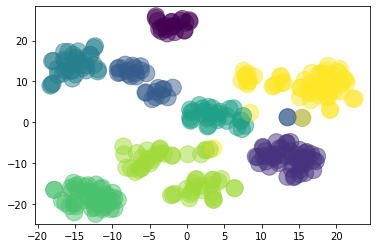

In [16]:
X = np.array(data['embediing_trf_roberta'].tolist())

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

Y=model.fit_transform(X)

plt.scatter(Y[:, 0], Y[:, 1], c=cluster_trf, s=290,alpha=.5)
plt.show()

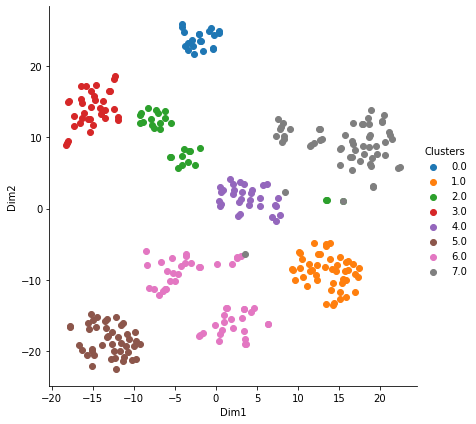

In [17]:
tnse_data=np.vstack((Y.T, cluster_trf)).T
tsne_df=pd.DataFrame(data=tnse_data, columns=('Dim1','Dim2','Clusters'))

sns.FacetGrid(tsne_df, hue="Clusters", size=6).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()

### Clustering by using KMean
#### Validating with silhouette analysis

For n_clusters=2, the silhouette score is 0.08633687347173691
For n_clusters=3, the silhouette score is 0.1007961556315422
For n_clusters=4, the silhouette score is 0.1256731003522873
For n_clusters=5, the silhouette score is 0.14161626994609833
For n_clusters=6, the silhouette score is 0.1498095840215683
For n_clusters=7, the silhouette score is 0.16271841526031494
For n_clusters=8, the silhouette score is 0.1696467101573944
For n_clusters=9, the silhouette score is 0.1782059669494629
For n_clusters=10, the silhouette score is 0.17725682258605957
For n_clusters=11, the silhouette score is 0.18852315843105316
For n_clusters=12, the silhouette score is 0.1593937873840332
For n_clusters=13, the silhouette score is 0.18462106585502625
For n_clusters=14, the silhouette score is 0.18433815240859985


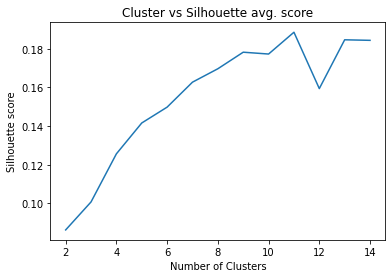

In [18]:
# silhouette analysis
import seaborn as sna
from sklearn.metrics import silhouette_score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8,9,10, 11, 12,13,14]
score =[]
for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters,max_iter=50, algorithm='auto', init='k-means++',n_init=10)
    kmeans.fit(list(data['embediing_trf_roberta']))
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(list(data['embediing_trf_roberta']), cluster_labels)
    score.append(silhouette_avg)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
sns.lineplot(range_n_clusters,score)
plt.title('Cluster vs Silhouette avg. score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette score')
plt.show()

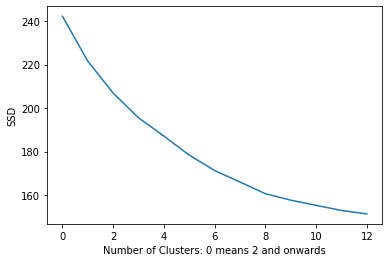

In [19]:
# elbow-curve/SSD
ssd=[]
range_n_clusters=[2, 3, 4, 5, 6, 7, 8,9,10, 11, 12,13,14]
for num_clusters in range_n_clusters:
    kmeans=KMeans(n_clusters=num_clusters,max_iter=50)
    kmeans.fit(list(data['embediing_trf_roberta']))
    ssd.append(kmeans.inertia_)
plt.plot(ssd)
plt.xlabel('Number of Clusters: 0 means 2 and onwards')
plt.ylabel('SSD')
plt.show()

In [18]:
from sklearn.model_selection import GridSearchCV
parameters={
            'init' : ['k-means++', 'random'],
            'algorithm' : ["auto", "full", "elkan"],
            'max_iter' : [50,100,200,300],
            'n_init' : [10,20,30]
    
            }
clustering_model = KMeans(n_clusters=num_clusters,n_jobs=-1)
grid = GridSearchCV(clustering_model, cv=5, param_grid = parameters, scoring = 
    silhouette_score)

grid.fit(list(data['embediing_trf_roberta']))
print(grid.best_params_)

{'algorithm': 'auto', 'init': 'k-means++', 'max_iter': 50, 'n_init': 10}


In [18]:
# Perform kmean clustering
num_clusters = 8
clustering_model = KMeans(n_clusters=num_clusters,max_iter=50, algorithm='auto', init='k-means++',n_init=10 )
clustering_model.fit(list(data['embediing_trf_roberta']))
cluster_assignment = clustering_model.labels_
data['Cluster_name']=cluster_assignment

In [19]:
data.tail()

,Test Case Description,Label,cleaned_text,embediing_trf_roberta,cluster_trf_roberta,centroid_trf_roberta,Cluster_name
312,Turn up volume to 9,Device,turn up volume to 9,"[0.090852164, 0.010219791, -0.005010192, 0.059732288, -0.035361107, -0.106628716, 0.05348276, -0.026637996, 0.07321968, 0.0015689877, 0.037704088, -0.057630632, 0.018576972, -0.0076315985, 0.00776...",5,"[0.040124904, 0.003930105, 0.0027377333, 0.02177268, -0.016319698, -0.009370942, 0.05083747, 0.001841396, 0.0481491, -0.023365354, 0.071882844, -0.037899394, -0.017194204, 0.021133749, 0.004871378...",0
313,turn volume down to 4,Device,turn volume down to 4,"[0.055512972, 0.019470114, -0.0019199268, 0.0453916, -0.030310571, -0.095655225, 0.021655777, 0.019903235, 0.0546393, -0.05215998, 0.034997158, -0.042039953, -0.020232206, -0.015372714, 0.01911280...",5,"[0.040124904, 0.003930105, 0.0027377333, 0.02177268, -0.016319698, -0.009370942, 0.05083747, 0.001841396, 0.0481491, -0.023365354, 0.071882844, -0.037899394, -0.017194204, 0.021133749, 0.004871378...",0
314,unmute,Device,unmute,"[0.020119736, -0.023103599, 0.02006422, -0.05686622, -0.010942112, -0.106926546, 0.0437913, 0.016071085, 0.057172846, -0.025881499, -0.038963947, 0.012979142, 0.01449345, -0.055043217, 0.004357977...",6,"[0.022011222, -0.009759659, 0.0026031677, -0.0050269864, -0.015182442, -0.05056214, 0.015300565, 0.011684107, 0.023545738, -0.037725095, 0.005371076, -0.01867192, 0.0071430374, -0.011623901, -0.02...",0
315,what is the brightness,Device,what is the brightness,"[0.016570581, -0.04098771, 0.029863186, 0.053355075, 0.023576481, 0.086313695, 0.033003207, 0.003380831, -0.034587353, 0.005385905, 0.09671995, -0.018418215, -0.028821941, 0.044008262, -0.03386857...",5,"[0.040124904, 0.003930105, 0.0027377333, 0.02177268, -0.016319698, -0.009370942, 0.05083747, 0.001841396, 0.0481491, -0.023365354, 0.071882844, -0.037899394, -0.017194204, 0.021133749, 0.004871378...",2
316,what is the volume right now,Device,what is the volume right now,"[0.037495866, 0.0075459164, 0.016088853, -0.014093855, 0.020723235, -0.010410288, 0.02018239, 0.0015585935, 0.009738118, -0.025520379, 0.0043569817, 0.013851292, -0.023777358, -0.046115253, 0.0102...",3,"[0.033139545, -0.0012308569, 0.0014227458, -0.020163331, 0.021691684, -0.006456442, 0.024877679, -0.03496945, 0.025607813, -0.0055923504, 0.0026519324, -0.005453817, 0.008678621, -0.034936283, -0....",0


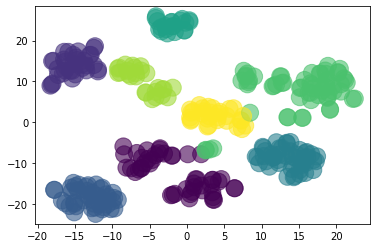

In [20]:
X = np.array(data['embediing_trf_roberta'].tolist())

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

Y=model.fit_transform(X)

plt.scatter(Y[:, 0], Y[:, 1], c=cluster_assignment, s=290,alpha=.6)
plt.show()

In [21]:
len(Y)

317

In [22]:
l2c = dict(zip(list(data.Label),data.Cluster_name))
sorted(l2c.items())
clusters= [y for x,y in sorted(l2c.items()) ]

In [23]:
sorted(l2c.items())

[('Alarm', 7),
 ('Calling', 5),
 ('Corona', 4),
 ('Device', 0),
 ('Integrity', 5),
 ('Time', 6),
 ('Timer', 3),
 ('Weather', 1)]

In [24]:
clusters

[7, 5, 4, 0, 5, 6, 3, 1]

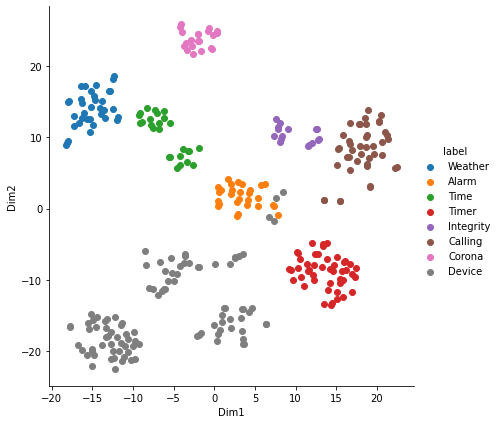

In [25]:
tnse_data=np.vstack((Y.T, data['Label'])).T
tsne_df=pd.DataFrame(data=tnse_data, columns=('Dim1','Dim2','label'))

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()

In [26]:
df=pd.DataFrame(data.groupby(['Label','Cluster_name'])['Cluster_name'].count())
df

Cluster_name
Label     Cluster_name              
Alarm     7                       28
Calling   5                       43
Corona    4                       21
Device    0                       48
          2                       45
          5                        5
          7                        3
Integrity 5                       16
Time      6                       26
Timer     3                       47
Weather   1                       35

In [27]:
df.rename(columns = {'Cluster_name':'Count'}, inplace = True)
df

Count
Label     Cluster_name       
Alarm     7                28
Calling   5                43
Corona    4                21
Device    0                48
          2                45
          5                 5
          7                 3
Integrity 5                16
Time      6                26
Timer     3                47
Weather   1                35

In [28]:
#df4=data[data['Cluster_name'].isin(clusters)].sort_values('Label')
df4=data.sort_values('Label')

In [29]:
clusters

[7, 5, 4, 0, 5, 6, 3, 1]

In [30]:

df5= pd.DataFrame(df4['Cluster_name'].value_counts(sort=False))
df5.rename(columns = {'Cluster_name':'Cluster_Count'}, inplace = True)
df5

,Cluster_Count
7,31
5,64
4,21
2,45
0,48
6,26
3,47
1,35


In [31]:
print(sorted(l2c.items()))

[('Alarm', 7), ('Calling', 5), ('Corona', 4), ('Device', 0), ('Integrity', 5), ('Time', 6), ('Timer', 3), ('Weather', 1)]


In [32]:
df3=pd.DataFrame(data['Label'].value_counts()).sort_index()

df3.rename(columns = {'Label':'Actual_Count'}, inplace = True)
df3

,Actual_Count
Alarm,28
Calling,43
Corona,21
Device,101
Integrity,16
Time,26
Timer,47
Weather,35


In [33]:

df3['Cluster_count']=list(df5['Cluster_Count'])
df3['Misclassified'] = abs(df3['Actual_Count']-df3['Cluster_count'])
df3

,Actual_Count,Cluster_count,Misclassified
Alarm,28,31,3
Calling,43,64,21
Corona,21,21,0
Device,101,45,56
Integrity,16,48,32
Time,26,26,0
Timer,47,47,0
Weather,35,35,0


In [34]:
df3['Cluster_count']=[31,48,21,93,16, 26,47,35]
df3['Misclassified'] = abs(df3['Actual_Count']-df3['Cluster_count'])
df3

,Actual_Count,Cluster_count,Misclassified
Alarm,28,31,3
Calling,43,48,5
Corona,21,21,0
Device,101,93,8
Integrity,16,16,0
Time,26,26,0
Timer,47,47,0
Weather,35,35,0


In [ ]:
l2c = dict(zip(list(data.Label),data.Cluster_name))
print(sorted(l2c.items()))
#clusters= [y for x,y in sorted(l2c.items()) ]
df4=data.sort_values('Label')
df5= pd.DataFrame(df4['Cluster_name'].value_counts(sort=False))
df5.rename(columns = {'Cluster_name':'Cluster_Count'}, inplace = True)
df3=pd.DataFrame(data['Label'].value_counts()).sort_index()
df3.rename(columns = {'Label':'Actual_Count'}, inplace = True)
df3['Cluster_count']=list(df5['Cluster_Count'])
df3['Misclassified'] = abs(df3['Actual_Count']-df3['Cluster_count'])
df3

In [107]:
df.reset_index(level=1, inplace=True)

In [108]:
df

,Cluster_name,Count
Label,,
Alarm,4,28
Calling,7,43
Corona,5,21
Device,2,45
Device,4,4
Device,6,48
Device,7,4
Integrity,4,9
Integrity,7,7


In [71]:
df.groupby(['Label','k_means_clstr'])['Count'].sum()

Label      k_means_clstr
Alarm      4                28
Calling    7                43
Corona     5                21
Device     2                45
           4                 4
           6                48
           7                 4
Integrity  4                 9
           7                 7
Time       1                25
           4                 1
Timer      0                47
Weather    3                35
Name: Count, dtype: int64

In [55]:
df.reset_index(level=0, inplace=True)

In [56]:
df

,k_means_clstr,Label,Count
0,4,Alarm,28
1,7,Calling,43
2,5,Corona,21
3,2,Device,45
4,4,Device,4
5,6,Device,48
6,7,Device,4
7,4,Integrity,9
8,7,Integrity,7
9,1,Time,25


In [ ]:
data.groupby(['Label', 'k_means_clstr']).size().reset_index(name='counts')

In [99]:
pd.set_option('display.max_rows', 500)
data[data['Cluster_name']==1][['cleaned_text','Label','Cluster_name']]

,cleaned_text,Label,Cluster_name
65,time,Time,1
236,set volume at 1,Device,1
237,set volume at 5,Device,1
238,set volume at 10,Device,1
239,volume to 100,Device,1
240,mute the volume,Device,1
242,as loud as possible please,Device,1
243,be quiet,Device,1
246,have an app open close the app,Device,1
247,could you turn this down a little bit,Device,1
